This is a bare-bones test program for loading and analyzing the output of ImageJ's TrackMate plugin (https://imagej.net/TrackMate). The plugin outputs a wealth of data in XML format, and this set of scripts provides an interface for loading and analyzing these data in Python.

In [1]:
import numpy as np
import matplotlib.pylab as plt
from os import path
from xml.dom import minidom

# Give the system a path to the data file
data_dir = '/Users/vbelyy/Desktop/TrackResults'
file_name = 'MMStack_Pos0.ome.test1.xml'

# Read data from the provided source file
full_path = path.join(data_dir, file_name)
full_file = minidom.parse(full_path)


The following cell contains common functions that help parse the raw data read out of the TrackMate xml files.

In [2]:
def pull_property_by_track(prop_name, all_spot_ids, all_spots):
    # Gather any (numerical) spot property for each track
    # 'prop_name' must be a valid key for 'all_spots'
    all_track_property = list() # stores numpy arrays of values
    for spot_ids in all_spot_ids:
        curr_prop_values = np.empty(len(spot_ids), dtype=float)
        for i, spot_id in enumerate(spot_ids):
            spot_ind = spot_id[1]
            curr_prop_values[i] = all_spots[spot_ind][prop_name]    
        all_track_property.append(curr_prop_values)
    return all_track_property

def build_spot_lists_by_track(tracks_raw, all_spots):
    # Build x,y spot coordinates for each track
    # 'all_tracks' and 'all_spots' are lists of dictionaries directly
    # from the output of the TrackMate plugin
    
    # Build an array of spot indices
    spot_ids = np.empty([len(spots)], dtype=int)
    for i, spot in enumerate(all_spots):
        spot_ids[i] = int(spot['ID'])
    
    all_track_edges = list()
    all_track_coords = list() # stores numpy arrays of x,y,t coords
    all_track_spot_ids = list() # stores spot IDs and indices for each track
    for track_raw in tracks_raw:
        curr_edges = track_raw.getElementsByTagName('Edge')
        track_name = track_raw.getAttribute('name')
        edges = list()
        for edge in curr_edges:
            edge_dict = dict(edge.attributes.items())
            edge_dict['track_name'] = track_name
            edges.append(edge_dict)

        edges.sort(key=lambda k: float(k['EDGE_TIME']))
        # build spot list
        num_spots = len(edges) + 1
        track_coords = np.empty([num_spots, 3], dtype=float) # x,y,t
        track_spot_ids = np.empty([num_spots, 2], dtype=int)
        for i in range(num_spots):
            if i==(num_spots-1): # get coords of last spot
                edge = edges[i-1]
                spot_id = int(edge['SPOT_TARGET_ID'])
            else:
                edge = edges[i]
                spot_id = int(edge['SPOT_SOURCE_ID'])
            spot_ind = np.where(spot_ids==spot_id)[0][0]

            track_spot_ids[i][0] = spot_id
            track_spot_ids[i][1] = spot_ind

            track_coords[i][0] = spots[spot_ind]['POSITION_X']
            track_coords[i][1] = spots[spot_ind]['POSITION_Y']
            track_coords[i][2] = spots[spot_ind]['POSITION_T']

        all_track_edges.append(edges)
        all_track_coords.append(track_coords)
        all_track_spot_ids.append(track_spot_ids)
    
    processed_tracks = (all_track_coords, all_track_edges, 
                            all_track_spot_ids)
    return processed_tracks

In [3]:
# Parse the data into tracks, creating lists of spots that
# make up each individual track (TrackMate assigns a unique
# spot ID to each spot in each frame, and their connections
# into multi-frame tracks are stored as 'Edge' elements)

# Convert the raw track data to a list of dictionaries
tracks = list()
tracks_raw = full_file.getElementsByTagName("Track")
for track_raw in tracks_raw:
    att = dict(track_raw.attributes.items())
    tracks.append(att)

# Compile a complete list of spots as a list of dictionaries
spots = list()
spots_by_frame = full_file.getElementsByTagName("SpotsInFrame")
for spots_curr_frame in spots_by_frame:
    curr_spots = spots_curr_frame.getElementsByTagName("Spot")
    for spot in curr_spots:
        att = dict(spot.attributes.items())
        spots.append(att)


processed_tracks = build_spot_lists_by_track(tracks_raw, spots)
track_coords, track_edges, track_spot_ids = processed_tracks

all_track_intensities = pull_property_by_track('MEAN_INTENSITY',
                                               track_spot_ids, spots)

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.03674134  0.01834631  0.04090766 ...,  0.02607497  0.58734494
   0.2269609 ]
 [ 0.07914661  0.051992    0.1212127  ...,         nan         nan
          nan]
 ..., 
 [        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.]


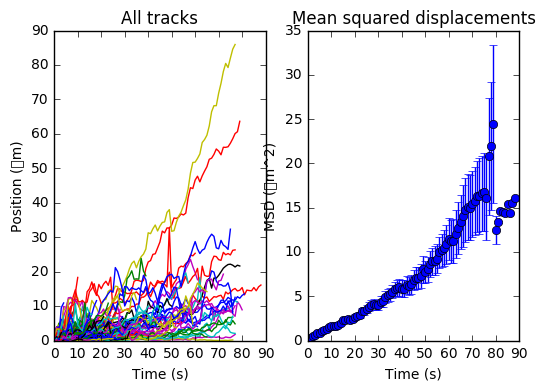

In [4]:
# Calculate MSD for each particle
from scipy import stats

t_dsq = list() # time vs sq. displacement for each particle
for track in track_coords:
    # 'track' is an array of x,y,t
    
    track_norm = track - track[0,:] # set x,y,t=0
    xy_sq = np.square(track_norm[:,0:2])
    d_sq = np.sum(xy_sq, axis=1)
    t = track_norm[:,2]
    tds = np.vstack((t, d_sq))
    tds = np.transpose(tds)
    
    t_dsq.append(tds)

# rebuild results as a padded numpy array for calculating means
l_max = max((len(el) for el in t_dsq))

d_sq = np.empty((l_max, len(t_dsq)))
t_total = np.empty((l_max, len(t_dsq)))
for i, x in enumerate(t_dsq):
    len1 = x.shape[0]
    pad_len = l_max - len1
    nanpad = np.empty([pad_len,2])*np.nan
    x_padded = np.concatenate((x,nanpad), axis=0)
    
    d_sq[:,i] = x_padded[:,1]
    t_total[:,i] = x_padded[:,0]
print(d_sq)
mean_t = np.nanmean(t_total, axis=1)
mean_dsq = np.nanmean(d_sq, axis=1)
std_dsq = np.nanstd(d_sq, axis=1)
sterr_dsq = stats.sem(d_sq, axis=1, nan_policy='omit',ddof=0)
print(mean_t)

# Plot results
f1, axarr = plt.subplots(1,2)
axarr[0].set_title('All tracks')
axarr[0].set_xlabel('Time (s)')
axarr[0].set_ylabel('Position (μm)')
axarr[1].set_title('Mean squared displacements')
axarr[1].set_xlabel('Time (s)')
axarr[1].set_ylabel('MSD (μm^2)')
for x in t_dsq:
    axarr[0].plot(x[:,0], x[:,1])


axarr[1].errorbar(mean_t, mean_dsq, yerr=sterr_dsq, fmt='o')
#axarr[1].plot(mean_t, mean_dsq)

plt.show()

In [5]:
# Plot some useful stuff

%matplotlib
#%matplotlib inline
import matplotlib.pylab as plt
#plt.xkcd()

# Various plotting tools
f2, axarr = plt.subplots(1,2)
axarr[0].set_title('All tracks')
axarr[0].set_xlabel('Position (μm)')
axarr[0].set_ylabel('Position (μm)')
axarr[1].set_xlabel('Time (s)')
axarr[1].set_ylabel('Intensity (A.U.)')
axarr[1].set_title('All intensities')
for i, track in enumerate(track_coords):
    axarr[0].plot(track[:,0], track[:,1])
    axarr[1].plot(track[:,2], all_track_intensities[i])
plt.show()
#plt.plot(track_coords[testind][:,2], all_track_intensities[testind])

Using matplotlib backend: MacOSX
